In [4]:
import os
os.chdir('C:\\Users\\Usuario\\Desktop\\wallace\\UNILA\\DNA IC')

In [7]:
import numpy as np
from biosppy.signals import tools
data2= open('splice.data.txt', 'r')
f= data2.readlines()
for i in range(len(f)):
    f[i]= f[i].split(',')
for i in range(len(f)):
    del(f[i][1])
for i in range(len(f)):
    f[i][1]=f[i][1].split()[0]
c=[]
for i in range(len(f)):
    b=[]
    if f[i][0]=='EI':
        b.append(0)
    elif f[i][0]=='IE':
        b.append(1)
    elif f[i][0]=='N':
        b.append(2)
    a=[]
    l=0
    for j in range(len(f[i][1])):
        if f[i][1][j]=='A':
            l= l-1
            a.append(l)
        elif f[i][1][j]=='C':
            l= l-2
            a.append(l)
        elif f[i][1][j]=='G':
            l= l+1
            a.append(l)
        elif f[i][1][j]=='T':
            l= l+2
            a.append(l)
        else:
            a.append(l)
    b.append(a)
    c.append(b)
cdata=[]
ctarg=[]

for i in range(len(c)):
    cdata.append(c[i][1])
    ctarg.append((c[i][0]))

#concatenando sequencias e self join
concatenado=[]
conc=[]
i=0
while ctarg[i] == 0:
    concatenado= concatenado + cdata[i]
    i=i+1
conc.append(concatenado)
concatenado=[]
while ctarg[i] == 1:
    concatenado= concatenado + cdata[i]
    i=i+1
conc.append(concatenado)
concatenado=[]
while i < len(ctarg):
    concatenado= concatenado + cdata[i]
    i=i+1
conc.append(concatenado)

zw= 11
win= 1
LMnn= []
for i in range(len(conc)):
    for m in range(4,zw,win):
        from biosppy.signals import tools
        ind , prof =tools.signal_self_join(signal=conc[i], size= m, index=None, limit=None)
        

        #'''minimos da matrix profile'''
        desv= prof.std()
        med= prof.mean()
        ln = len(prof)
        M= []
        for c in range(ln -1):
            if (prof[c - 1]>prof[c]<prof[c + 1]):
                if( prof[c]<0.1):
                    if(c%60+m<60):
                        M.append(c)


        #'''lista de motifs normalizados'''
        for e in range(len(M)):
            f= concatenado[M[e]:M[e]+m]
            LMnn.append(f)
    print('quantidade de subsequencias',len(LMnn))

#2 tabela de distancia entre motifs
DistMotifs= []
DMp=[]
LM= LMnn
for i in range(len(LM)):
    for j in range(i+1,len(LM)):
        if(len(LM[i])<=len(LM[j])/2):
            eucli = tools.distance_profile(query=LM[i], signal=LM[j], metric='euclidean')
            eucli=eucli[0]
        elif(len(LM[i])/2>=len(LM[j])):
            eucli = tools.distance_profile(query=LM[j], signal=LM[i], metric='euclidean')
            eucli=eucli[0]
        else:
            
            if(len(LM[i])>=len(LM[j])):
                o=[]
                o= np.concatenate((LM[i], LM[i]), axis=0)
                eucli = tools.distance_profile(query=LM[j], signal=o, metric='euclidean')
                eucli= eucli[0]
                a=[]
                for b in range(len(LM[i])-len(LM[j])+1):
                    a.append(eucli[b])
                eucli= a
            elif(len(LM[i])<len(LM[j])):
                o=[]
                o= np.concatenate((LM[j], LM[j]), axis=0)
                eucli = tools.distance_profile(query=LM[i], signal=o, metric='euclidean')
                eucli= eucli[0]
                a=[]
                for b in range(len(LM[j])-len(LM[i])+1):
                    a.append(eucli[b])
                eucli= a
             
        DMp.append(np.min(eucli))
    DistMotifs.append(DMp)
    DMp= []
import pickle
l=DistMotifs
with open("distmotifs.txt", 'wb') as fp:
    pickle.dump(l, fp)

#3 Agrupamento - variando o raio para o agrupamento, guardando raio e medida de qualidade
ra=[]
sel=0
medidaqualidade= []
informacao=[]
for rai in range(1, 11, 1):
    with open('distmotifs.txt', 'rb') as fp:
        D= pickle.load(fp)
    raio= rai/10
    # agrupando motifs
    g=[]
    for a in range(len(D)):
        gg=[]
        c= a - 1
        h=0
        for u in range(len(g)):
            if c not in (g[u]):
                h=h+1
        if(h==len(g)):
            if D[a] != []:
                gg.append(a-1)
                for p in range(int(zw/win)-2):
                    b= np.argmin(D[a])
                    c= b + a
                    h=0
                    for u in range(len(g)):
                        if c not in (g[u]):
                            h= h + 1
                    if(h==len(g)):
                        gg.append(c)
                        D[a][b]= 50
                for d in range(len(D[a])):
                    if(D[a][d]<=(np.min(D[a])+ raio)):
                        c= a+d
                        h=0
                        for u in range(len(g)):
                            if c not in (g[u]):
                                h= h + 1
                        if(h==len(g)):
                            gg.append(c)
                g.append(gg)

    
    #comparacao de distancias intra grupo
    cccc=0
    o=[]
    gg= []
    for f in range(len(g)):
        if(len(g[f])<2):
            gg.append(f)
    for f in range(len (gg) - 1, -1, -1):
        del(g[gg[f]])

    for u in range(len(g)):
        i=[]
        for v in range(len(g[u])):
            j=[]
            for l in range(len(g[u])):
                if(g[u][v]!=g[u][l]):
                    if(g[u][v]<g[u][l]):
                        j.append(DistMotifs[g[u][v] + 1][g[u][l]- g[u][v] - 1])
                    else:
                        j.append(DistMotifs[g[u][l] + 1][g[u][v]- g[u][l] - 1])
            a=0
            for n in range(len(j)):
                a= a + j[n]
            a= a/len(j)
            i.append(a)
        o.append(i)
    medg=[]
    centroides=[]
    for r in range(len(o)):
        centroides.append(np.argmin(o[r]))
        medg.append(np.min(o[r]))
    me=0
    for r in range(len(medg)):
        me= me + medg[r]
    valorintra= me/len(o)

    #comparacao de distancias extra grupos
    centros=[]
    i=[]
    for l in range(len(centroides)):
        centros.append(g[l][centroides[l]])
    a=0
    for v in range(len(centros)):
        j=[]
        for l in range(len(centros)):
            if(centros[v]!=centros[l]):
                if(centros[v]<centros[l]):
                    j.append(DistMotifs[centros[v] + 1][centros[l]- centros[v] - 1])
                else:
                    j.append(DistMotifs[centros[l] + 1][centros[v]- centros[l] - 1])
        if j==[]:print(centros)
        a= min(j)
        i.append(a)
    a=0
    for n in range(len(i)):
        a= a + i[n]
    valorextra= a/len(i)   
    #medida de qualidade
    print('grupos',len(g))
    print('ve',valorextra,'vi', valorintra)
    mq= (valorextra - valorintra)/max(valorintra, valorextra)
    ra.append(raio)
    medidaqualidade.append(mq)
    print('medidade de qualidade para ', raio, ' : ', mq)
    
    #selecao representantes do melhor agrupamento
    representantes=[] 
    if mq>sel:
        sel=mq
        for i in range(len(centros)):
            representantes.append(LMnn[centros[i]])
        import pickle
        l=representantes
        with open("representantes.txt", 'wb') as fp:
            pickle.dump(l, fp)
informacao.append(ra)
informacao.append(medidaqualidade)
with open("informacao.txt", 'wb') as fp:
    pickle.dump(informacao, fp)

#tabela de atributo valor
tabela=[]
with open('representantes.txt', 'rb') as fp:
        Rep= pickle.load(fp)
for i in range(len(cdata)):
    a=cdata[i]
    linha=[]
    for j in range(len(Rep)):
        b= Rep[j]
        eucli = tools.distance_profile(query=b, signal=a, metric='euclidean')
        eucli= eucli[0]
        ln = len(eucli)
        contador= 0
        for c in range(ln -1):
            if (eucli[c - 1]>eucli[c]<eucli[c + 1]):
                if( eucli[c]< 0.1):
                    contador= contador + 1
        linha.append(contador)
    tabela.append(linha)
with open("tabela atributo-valor.txt", 'wb') as fp:
    pickle.dump(tabela, fp)

quantidade de subsequencias 81
quantidade de subsequencias 177
quantidade de subsequencias 254
grupos 29
ve 0.5260879980136813 vi 4.217911005844661e-08
medidade de qualidade para  0.1  :  0.9999999198249908
grupos 26
ve 0.49186275625484954 vi 0.01777090191410917
medidade de qualidade para  0.2  :  0.9638702022299458
grupos 25
ve 0.5996528680577984 vi 0.01386272632956456
medidade de qualidade para  0.3  :  0.9768820811706209
grupos 22
ve 0.6822834650088017 vi 0.018800411441881413
medidade de qualidade para  0.4  :  0.9724448672640208
grupos 15
ve 0.7470189839154947 vi 0.08578919472124855
medidade de qualidade para  0.5  :  0.8851579456902352
grupos 15
ve 0.7470189839154947 vi 0.08651035679135698
medidade de qualidade para  0.6  :  0.8841925591530304
grupos 11
ve 1.2026097168987213 vi 0.22240022439293072
medidade de qualidade para  0.7  :  0.8150686617047679
grupos 11
ve 1.2026097168987213 vi 0.22240022439293072
medidade de qualidade para  0.8  :  0.8150686617047679
grupos 10
ve 1.435269

C:\Users\Usuario\Anaconda3\lib\site-packages\biosppy\signals\tools.py:1477: RuntimeWarning: divide by zero encountered in true_divide
  dist = 2 * m * (1 - z / (m * sigma))
C:\Users\Usuario\Anaconda3\lib\site-packages\biosppy\signals\tools.py:1477: RuntimeWarning: invalid value encountered in true_divide
  dist = 2 * m * (1 - z / (m * sigma))
C:\Users\Usuario\Anaconda3\lib\site-packages\biosppy\signals\tools.py:1477: RuntimeWarning: invalid value encountered in multiply
  dist = 2 * m * (1 - z / (m * sigma))


In [3]:
print(tabela[0:9])

[[0, 0, 1, 5, 1, 5, 2, 1, 0, 1, 0, 0, 5, 0, 2, 3, 1, 3, 3, 1, 2, 2, 5, 5, 1], [0, 4, 0, 1, 2, 3, 1, 0, 0, 0, 0, 1, 3, 2, 1, 3, 1, 1, 3, 0, 0, 1, 1, 3, 0], [0, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 2, 4, 1, 1, 4, 2, 1, 4, 0, 2, 0, 2, 2, 0], [0, 1, 1, 1, 3, 0, 4, 1, 0, 4, 0, 0, 2, 0, 4, 2, 3, 0, 2, 0, 1, 3, 1, 0, 0], [0, 6, 0, 3, 0, 1, 1, 1, 1, 0, 0, 3, 3, 0, 1, 1, 1, 3, 1, 1, 2, 1, 3, 1, 0], [0, 1, 3, 2, 2, 3, 1, 0, 0, 1, 0, 0, 2, 0, 1, 2, 2, 2, 2, 0, 0, 1, 2, 3, 3], [1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 3, 1, 1, 2, 2, 2, 2, 1, 0, 2, 2, 1, 1], [0, 0, 0, 2, 3, 1, 2, 0, 2, 0, 0, 1, 1, 0, 2, 0, 3, 4, 0, 0, 2, 0, 2, 1, 1], [1, 3, 0, 1, 0, 4, 3, 0, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 2, 3, 1, 4, 0]]


In [4]:
import numpy as np
from biosppy.signals import tools
data1= open('splice.data.txt', 'r')
f= data1.readlines()
for i in range(len(f)):
    f[i]= f[i].split(',')
for i in range(len(f)):
    del(f[i][1])
for i in range(len(f)):
    f[i][1]=f[i][1].split()[0]
c=[]
for i in range(len(f)):
    b=[]
    if f[i][0]=='EI':
        b.append(0)
    elif f[i][0]=='IE':
        b.append(1)
    elif f[i][0]=='N':
        b.append(2)
    a=[]
    for j in range(len(f[i][1])):
        if f[i][1][j]=='A':
            a.append(0)
        elif f[i][1][j]=='C':
            a.append(1)
        elif f[i][1][j]=='G':
            a.append(2)
        elif f[i][1][j]=='T':
            a.append(3)
        else:
            a.append(8)
    b.append(a)
    c.append(b)
cdata=[]
ctarg=[]

for i in range(len(c)):
    cdata.append(c[i][1])
    ctarg.append((c[i][0]))
    
#concatenando sequencias
concatenado=[]
conc=[]
i=0
while ctarg[i] == 0:
    concatenado= concatenado + cdata[i]
    i=i+1
conc.append(concatenado)
concatenado=[]
while ctarg[i] == 1:
    concatenado= concatenado + cdata[i]
    i=i+1
conc.append(concatenado)
concatenado=[]
while i < len(ctarg):
    concatenado= concatenado + cdata[i]
    i=i+1
conc.append(concatenado)


zw= 10
win= 1
LMnn= []
for i in range(len(conc)):
    for m in range(4,zw,win):
        from biosppy.signals import tools
        ind , prof =tools.signal_self_join(signal=conc[i], size= m, index=None, limit=None)


        #'''minimos da matrix profile'''
        desv= prof.std()
        med= prof.mean()
        ln = len(prof)
        M= []
        for c in range(ln -1):
            if (prof[c - 1]>prof[c]<prof[c + 1]):
                if( prof[c]<0.1):
                    if(c%60+m<60):
                        M.append(c)


        #'''lista de motifs normalizados'''
        for e in range(len(M)):
            f= concatenado[M[e]:M[e]+m]
            LMnn.append(f)
    print('quentidade de subsequencias',len(LMnn))

#2 tabela de distancia entre motifs
DistMotifs= []
DMp=[]
LM= LMnn
for i in range(len(LM)):
    for j in range(i+1,len(LM)):
        if(len(LM[i])<=len(LM[j])/2):
            eucli = tools.distance_profile(query=LM[i], signal=LM[j], metric='euclidean')
            eucli=eucli[0]
        elif(len(LM[i])/2>=len(LM[j])):
            eucli = tools.distance_profile(query=LM[j], signal=LM[i], metric='euclidean')
            eucli=eucli[0]
        else:
            
            if(len(LM[i])>=len(LM[j])):
                o=[]
                o= np.concatenate((LM[i], LM[i]), axis=0)
                eucli = tools.distance_profile(query=LM[j], signal=o, metric='euclidean')
                eucli= eucli[0]
                a=[]
                for b in range(len(LM[i])-len(LM[j])+1):
                    a.append(eucli[b])
                eucli= a
            elif(len(LM[i])<len(LM[j])):
                o=[]
                o= np.concatenate((LM[j], LM[j]), axis=0)
                eucli = tools.distance_profile(query=LM[i], signal=o, metric='euclidean')
                eucli= eucli[0]
                a=[]
                for b in range(len(LM[j])-len(LM[i])+1):
                    a.append(eucli[b])
                eucli= a
             
        DMp.append(np.min(eucli))
    DistMotifs.append(DMp)
    DMp= []
import pickle
l=DistMotifs
with open("distmotifs2.txt", 'wb') as fp:
    pickle.dump(l, fp)

#3 Agrupamento - variando o raio para o agrupamento, guardando raio e medida de qualidade
ra=[]
sel=0
medidaqualidade= []
informacao=[]
for rai in range(1, 11, 1):
    with open('distmotifs2.txt', 'rb') as fp:
        D= pickle.load(fp)
    raio= rai/10
    # agrupando motifs
    g=[]
    for a in range(len(D)):
        gg=[]
        c= a - 1
        h=0
        for u in range(len(g)):
            if c not in (g[u]):
                h=h+1
        if(h==len(g)):
            if D[a] != []:
                gg.append(a-1)
                for p in range(int(zw/win)-2):
                    b= np.argmin(D[a])
                    c= b + a
                    h=0
                    for u in range(len(g)):
                        if c not in (g[u]):
                            h= h + 1
                    if(h==len(g)):
                        gg.append(c)
                        D[a][b]= 50
                for d in range(len(D[a])):
                    if(D[a][d]<=(np.min(D[a])+ raio)):
                        c= a+d
                        h=0
                        for u in range(len(g)):
                            if c not in (g[u]):
                                h= h + 1
                        if(h==len(g)):
                            gg.append(c)
                g.append(gg)

    
    #comparacao de distancias intra grupo
    c=0
    o=[]
    gg= []
    for f in range(len(g)):
        if(len(g[f])<2):
            gg.append(f)
    for f in range(len (gg) - 1, -1, -1):
        del(g[gg[f]])

    for u in range(len(g)):
        i=[]
        for v in range(len(g[u])):
            j=[]
            for l in range(len(g[u])):
                if(g[u][v]!=g[u][l]):
                    if(g[u][v]<g[u][l]):
                        j.append(DistMotifs[g[u][v] + 1][g[u][l]- g[u][v] - 1])
                    else:
                        j.append(DistMotifs[g[u][l] + 1][g[u][v]- g[u][l] - 1])
            a=0
            for n in range(len(j)):
                a= a + j[n]
            a= a/len(j)
            i.append(a)
        o.append(i)
    medg=[]
    centroides=[]
    for r in range(len(o)):
        centroides.append(np.argmin(o[r]))
        medg.append(np.min(o[r]))
    me=0
    for r in range(len(medg)):
        me= me + medg[r]
    valorintra= me/len(o)

    #comparacao de distancias extra grupos
    centros=[]
    i=[]
    for l in range(len(centroides)):
        centros.append(g[l][centroides[l]])
    a=0
    for v in range(len(centros)):
        j=[]
        for l in range(len(centros)):
            if(centros[v]!=centros[l]):
                if(centros[v]<centros[l]):
                    j.append(DistMotifs[centros[v] + 1][centros[l]- centros[v] - 1])
                else:
                    j.append(DistMotifs[centros[l] + 1][centros[v]- centros[l] - 1])
        if j==[]:print(centros)
        a= min(j)
        i.append(a)
    a=0
    for n in range(len(i)):
        a= a + i[n]
    valorextra= a/len(i)   
    #medida de qualidade
    print('grupos',len(g))
    print('ve',valorextra,'vi', valorintra)
    mq= (valorextra - valorintra)/max(valorintra, valorextra)
    ra.append(raio)
    medidaqualidade.append(mq)
    print('medidade de qualidade para ', raio, ' : ', mq)
    
    #selecao representantes do melhor agrupamento
    representantes=[] 
    if mq>sel:
        sel=mq
        for i in range(len(centros)):
            representantes.append(LMnn[centros[i]])
        import pickle
        l=representantes
        with open("representantes2.txt", 'wb') as fp:
            pickle.dump(l, fp)
informacao.append(ra)
informacao.append(medidaqualidade)
with open("informacao2.txt", 'wb') as fp:
    pickle.dump(informacao, fp)

#tabela de atributo valor
tabela=[]
with open('representantes2.txt', 'rb') as fp:
        Rep= pickle.load(fp)
for i in range(len(cdata)):
    a=cdata[i]
    linha=[]
    for j in range(len(Rep)):
        b= Rep[j]
        eucli = tools.distance_profile(query=b, signal=a, metric='euclidean')
        eucli= eucli[0]
        ln = len(eucli)
        contador= 0
        for c in range(ln -1):
            if (eucli[c - 1]>eucli[c]<eucli[c + 1]):
                if( eucli[c]< 0.1):
                    contador= contador + 1
        linha.append(contador)
    tabela.append(linha)
with open("tabela atributo-valor2.txt", 'wb') as fp:
    pickle.dump(tabela, fp)

C:\Users\Usuario\Anaconda3\lib\site-packages\biosppy\signals\tools.py:1477: RuntimeWarning: divide by zero encountered in true_divide
  dist = 2 * m * (1 - z / (m * sigma))
C:\Users\Usuario\Anaconda3\lib\site-packages\biosppy\signals\tools.py:1477: RuntimeWarning: invalid value encountered in multiply
  dist = 2 * m * (1 - z / (m * sigma))
C:\Users\Usuario\Anaconda3\lib\site-packages\biosppy\signals\tools.py:1644: RuntimeWarning: invalid value encountered in less
  pos = dist < matrix_profile
C:\Users\Usuario\Anaconda3\lib\site-packages\biosppy\signals\tools.py:1477: RuntimeWarning: invalid value encountered in true_divide
  dist = 2 * m * (1 - z / (m * sigma))
C:\Users\Usuario\Anaconda3\lib\site-packages\biosppy\signals\tools.py:1465: RuntimeWarning: invalid value encountered in true_divide
  q = (query - np.mean(query)) / np.std(query)


quentidade de subsequencias 7
quentidade de subsequencias 13
quentidade de subsequencias 34
grupos 4
ve 1.6543383444211794 vi 1.1609009984331253
medidade de qualidade para  0.1  :  0.2982686991763454
grupos 6
ve 1.3562469832900197 vi 0.9778510170587867
medidade de qualidade para  0.2  :  0.2790022546728989
grupos 6
ve 1.3562469832900197 vi 1.073764890014152
medidade de qualidade para  0.3  :  0.2082821910435628
grupos 6
ve 1.3562469832900197 vi 1.073764890014152
medidade de qualidade para  0.4  :  0.2082821910435628
grupos 6
ve 1.3562469832900197 vi 1.073764890014152
medidade de qualidade para  0.5  :  0.2082821910435628
grupos 5
ve 1.7014589041549464 vi 1.36076606855328
medidade de qualidade para  0.6  :  0.20023571228767129
grupos 4
ve 2.0088017843479524 vi 1.51045260872877
medidade de qualidade para  0.7  :  0.24808280214712386
grupos 4
ve 2.0088017843479524 vi 1.51045260872877
medidade de qualidade para  0.8  :  0.24808280214712386
grupos 3
ve 2.101052109940978 vi 1.576536838185060

In [14]:
 with open('distmotifs2.txt', 'rb') as fp:
        Di= pickle.load(fp)
D=str(conc)
D.find('nan')

-1

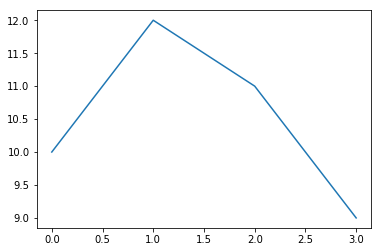

In [10]:
with open('representantes.txt', 'rb') as fp:
        Rep= pickle.load(fp)
import matplotlib.pyplot as plt
plt.plot(Rep[0])
plt.show()

In [15]:
a=[0,0,0,0]
b=1
c= a+b
print(c)

TypeError: can only concatenate list (not "int") to list

In [8]:
print(len(cdata))

3190
